# Training more sophisticated VAEs

- Perceptual loss
- Supervised classifications
- Deeper (+ residual) models

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

import torch.nn.functional as F


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data

In [3]:
!wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

--2020-12-08 20:51:17--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M) [text/plain]
Saving to: ‘Galaxy10.h5’

Galaxy10.h5         100%[===================>] 200.50M  89.3MB/s    in 2.2s    

2020-12-08 20:51:19 (89.3 MB/s) - ‘Galaxy10.h5’ saved [210234548/210234548]



In [4]:
# load entire file into memory
with h5py.File('Galaxy10.h5', 'r') as f:
    images = np.array(f['images'])
    labels = np.array(f['ans'])

images = (images / 255.).astype(np.float32)

In [5]:
class GalaxyDataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [6]:
N = len(images)

np.random.seed(12345)
indices = np.random.permutation(N)
train_idxs = indices[:int(0.8*N)]
valid_idxs = indices[int(0.8*N):]

In [7]:
transform = transforms.ToTensor()

train_ds = GalaxyDataset(images[train_idxs], labels[train_idxs], transform)
valid_ds = GalaxyDataset(images[valid_idxs], labels[valid_idxs], transform)

train_loader = DataLoader(
    train_ds,
    batch_size=128,
    num_workers=1,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

valid_loader = DataLoader(
    valid_ds,
    batch_size=128,
    num_workers=1,
    shuffle=True,
    pin_memory=torch.cuda.is_available()
)

# VAE basics

In [134]:
class ConvVAE(nn.Module):
    def __init__(self, d):
        super().__init__()

        self.d = d

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, padding=1),    # 35x35
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 2, padding=1),   # 18x18
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*18*18, 2*d)
        )

        self.dec1 = nn.Sequential(
            nn.Linear(d, 32*18*18),
            nn.Unflatten(1, (32, 18, 18)), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 1, padding=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, 3, 1, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        mu_logvar = self.enc3(x).view(-1, 2, self.d)

        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]

        z = self.reparameterize(mu, logvar)

        x_hat = self.dec1(z)
        x_hat = F.interpolate(x_hat, size=(35, 35), mode='bilinear')

        x_hat = self.dec2(x_hat)
        x_hat = F.interpolate(x_hat, size=(69, 69), mode='bilinear')
        return self.dec3(x_hat), mu, logvar

In [135]:
def display_images(in_, out, nrows=1, ncols=4, label=None, count=False):
    for row in range(nrows):
        if in_ is not None:
            in_pic = np.array(in_.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))
            plt.figure(figsize=(18, 4))
            plt.suptitle(label, color='w', fontsize=16)
            for col in range(ncols):
                plt.subplot(1, ncols, col + 1)
                plt.imshow(in_pic[col + ncols * row])
                plt.axis('off')
        out_pic = np.array(out.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))
        plt.figure(figsize=(18, 6))
        for col in range(ncols):
            plt.subplot(1, ncols, col + 1)
            plt.imshow(out_pic[col + ncols * row])
            plt.axis('off')
            if count: plt.title(str(col + ncols * row), color='w')

# Perceptual loss

Perceptual loss forces the intermediate features of the autoencoded and original image to be similar. In some sense this promotes reconstructed images to have similar textures as real images.

Since the first conv layer features really dominate the signal, I downweight those features.

(I probably should use Pytorch hooks to implement this.)

In [136]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)
    y = y.unsqueeze(0) 
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2) 
    return torch.exp(-kernel_input) # (x_size, y_size)
    
def compute_mmd(x, y):
    xx_kernel = compute_kernel(x,x)
    yy_kernel = compute_kernel(y,y)
    xy_kernel = compute_kernel(x,y)
    return torch.mean(xx_kernel) + torch.mean(yy_kernel) - 2*torch.mean(xy_kernel)


def perceptual_MMD_loss(m, x_hat, x, mu, logvar, weights=[0.1, 1.0], alpha=1.0, beta=1.0):

    mse_f = torch.nn.MSELoss(reduction='sum')
    MSE = mse_f(x_hat, x) / x.size(1)

    with torch.no_grad():
        x_1 = m.enc1(x)
        x_2 = m.enc2(x_1)

        x_hat_1 = m.enc1(x_hat)
        x_hat_2 = m.enc2(x_hat_1)

        perceptual_1 = mse_f(x_1, x_hat_1) / x_1.size(1)
        perceptual_2 = mse_f(x_2, x_hat_2) / x_2.size(1)

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    true_samples = torch.autograd.Variable(
        torch.randn(200, model.d), 
        requires_grad=False
    ).to(device)
    z = model.reparameterize(mu, logvar) 
    MMD = compute_mmd(true_samples, z) * x.size(0) * model.d

    return MSE + weights[0] * perceptual_1 + weights[1] * perceptual_2 + (1 - alpha)*KLD + (beta + alpha-1)*MMD


In [137]:
model = ConvVAE(d=50).to(device)

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


 Epoch 0 | Train: 265.3 | Valid: 107.1


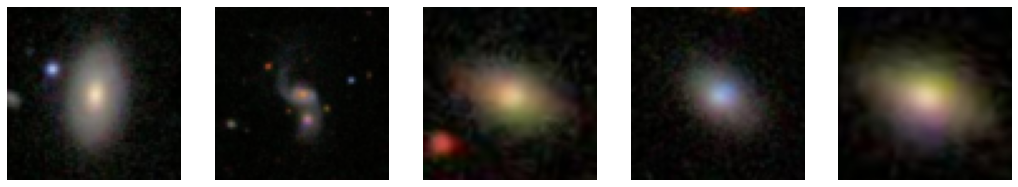

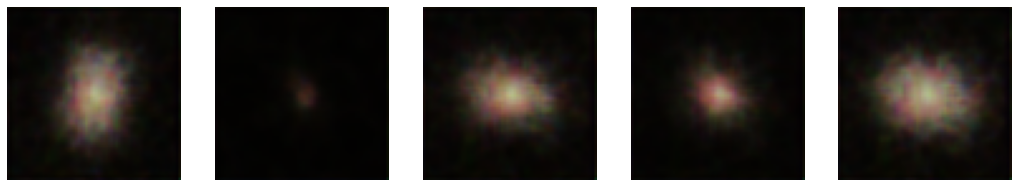

 Epoch 1 | Train: 105.0 | Valid: 86.2
 Epoch 2 | Train: 87.1 | Valid: 93.1
 Epoch 3 | Train: 79.1 | Valid: 76.2
 Epoch 4 | Train: 71.9 | Valid: 65.5
 Epoch 5 | Train: 64.7 | Valid: 70.7
 Epoch 6 | Train: 79.1 | Valid: 604.2
 Epoch 7 | Train: 48.5 | Valid: 54.0
 Epoch 8 | Train: 42.6 | Valid: 44.3
 Epoch 9 | Train: 40.6 | Valid: 49.8
 Epoch 10 | Train: 39.7 | Valid: 40.6


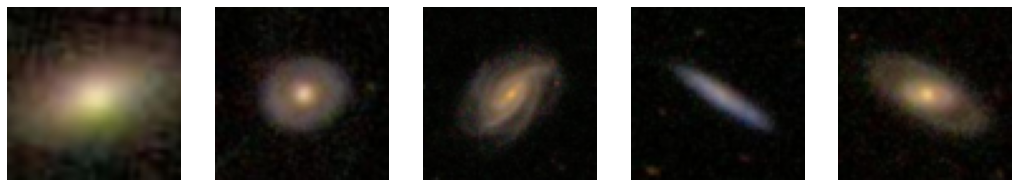

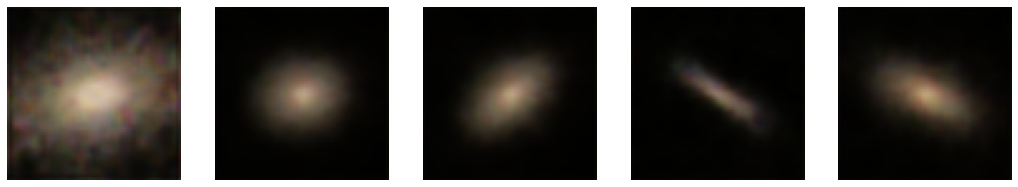

 Epoch 11 | Train: 38.8 | Valid: 43.2
 Epoch 12 | Train: 38.1 | Valid: 42.1
 Epoch 13 | Train: 37.3 | Valid: 40.1
 Epoch 14 | Train: 36.3 | Valid: 38.6
 Epoch 15 | Train: 36.9 | Valid: 36.7
 Epoch 16 | Train: 35.3 | Valid: 38.3
 Epoch 17 | Train: 34.5 | Valid: 38.9
 Epoch 18 | Train: 34.0 | Valid: 38.8
 Epoch 19 | Train: 33.5 | Valid: 35.9
 Epoch 20 | Train: 33.2 | Valid: 36.1


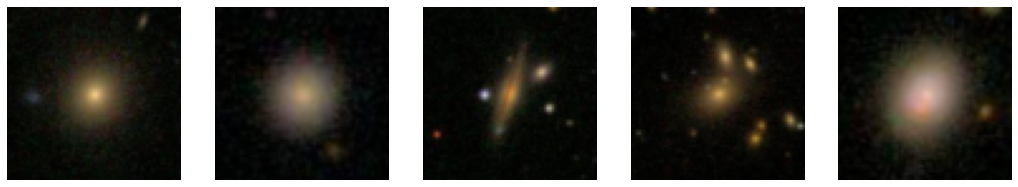

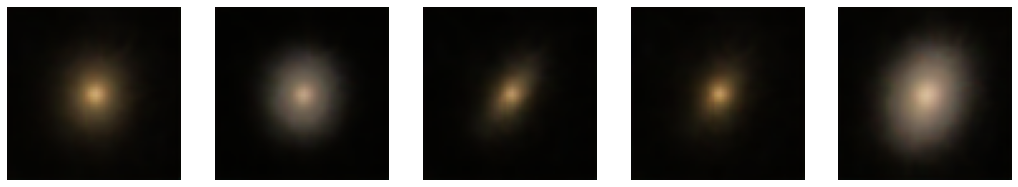

 Epoch 21 | Train: 32.8 | Valid: 33.9
 Epoch 22 | Train: 32.3 | Valid: 35.9
 Epoch 23 | Train: 32.1 | Valid: 39.2
 Epoch 24 | Train: 31.6 | Valid: 33.1
 Epoch 25 | Train: 31.4 | Valid: 34.4
 Epoch 26 | Train: 30.7 | Valid: 35.6
 Epoch 27 | Train: 30.4 | Valid: 33.7
 Epoch 28 | Train: 29.7 | Valid: 33.5
 Epoch 29 | Train: 29.1 | Valid: 32.4
 Epoch 30 | Train: 28.6 | Valid: 36.5


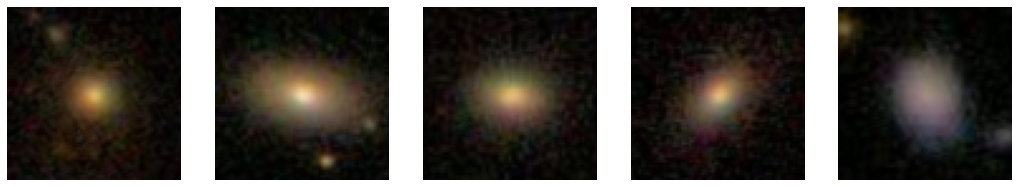

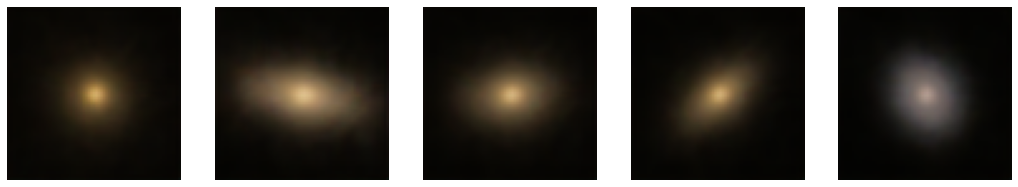

 Epoch 31 | Train: 27.9 | Valid: 31.0
 Epoch 32 | Train: 27.3 | Valid: 30.7
 Epoch 33 | Train: 26.9 | Valid: 30.7
 Epoch 34 | Train: 26.5 | Valid: 30.2
 Epoch 35 | Train: 26.0 | Valid: 28.9
 Epoch 36 | Train: 25.7 | Valid: 30.1
 Epoch 37 | Train: 25.1 | Valid: 27.8
 Epoch 38 | Train: 24.8 | Valid: 28.0
 Epoch 39 | Train: 24.4 | Valid: 29.0
 Epoch 40 | Train: 23.9 | Valid: 27.5


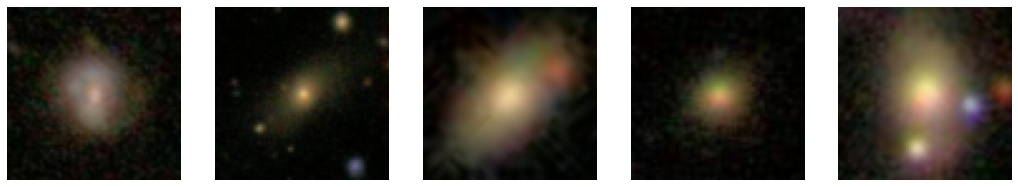

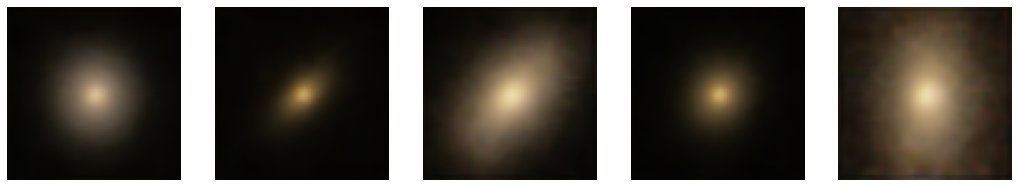

 Epoch 41 | Train: 23.5 | Valid: 29.2
 Epoch 42 | Train: 23.1 | Valid: 30.1
 Epoch 43 | Train: 22.8 | Valid: 28.4
 Epoch 44 | Train: 22.5 | Valid: 25.5
 Epoch 45 | Train: 22.1 | Valid: 26.0
 Epoch 46 | Train: 21.7 | Valid: 26.4
 Epoch 47 | Train: 21.6 | Valid: 25.1
 Epoch 48 | Train: 21.2 | Valid: 25.6
 Epoch 49 | Train: 20.9 | Valid: 25.2
 Epoch 50 | Train: 20.6 | Valid: 24.5


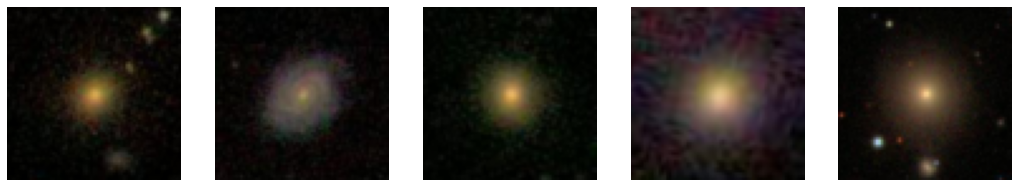

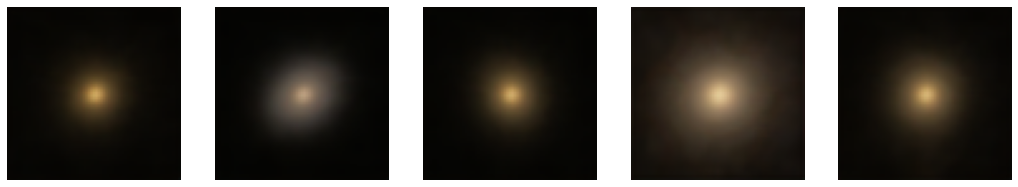

In [138]:
validation_losses = []

for epoch in range(0, 51):
    # train
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        loss = perceptual_MMD_loss(model, x_hat, x, mu, logvar, weights=[0.1, 1.], alpha=0.5, beta=1.)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    # validate
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        for x, y in valid_loader:
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            valid_loss += perceptual_MMD_loss(model, x_hat, x, mu, logvar, weights=[0.1, 1.], alpha=0.5, beta=1.)
            
    validation_losses.append(valid_loss / len(valid_loader.dataset))
    print(f' Epoch {epoch} | Train: {train_loss / len(train_loader.dataset):.1f} | Valid: {validation_losses[-1]:.1f}')

    # display
    if epoch % 10 == 0:
        display_images(x, x_hat, 1, 5)
        plt.show()

The combination of all these terms (MSE, perceptual, MMD) can make training a bit unstable if we downweight KL divergence too much (i.e., `alpha=0.9` is **bad**)

## Look at features

In [139]:
mu_list = []
y_list = []
with torch.no_grad():
    model.eval()

    for x, y in valid_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        
        mu_list.append(mu)
        y_list.append(y)

mu_list = torch.cat(mu_list).cpu()
y_list = torch.cat(y_list).cpu()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [140]:
pca = PCA(n_components=10)
mu_pca_list = pca.fit_transform(mu_list)
pca.explained_variance_ratio_

array([0.1826529 , 0.14546481, 0.14352739, 0.11394049, 0.06569568,
       0.05312127, 0.04668989, 0.02446229, 0.02283457, 0.02036074])

In [141]:
with torch.no_grad():
    model.eval()

    x, y = next(iter(valid_loader))

x = x.to(device)
x_hat, *_ = model(x)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [142]:

def decode(vae_model, z):
    x_hat = vae_model.dec1(z)
    x_hat = F.interpolate(x_hat, size=(35, 35), mode='bilinear')

    x_hat = vae_model.dec2(x_hat)
    x_hat = F.interpolate(x_hat, size=(69, 69), mode='bilinear')

    return vae_model.dec3(x_hat)

In [143]:
latent_mu_stats = np.array([np.quantile(mu_pca_list[:, i], [0.005, 0.025, 0.16, 0.5, 0.84, 0.975, 0.995]) for i in range(10)]).T

N_samples = 7

latent_vecs_pca = np.column_stack([latent_mu_stats[:, 0], np.zeros((N_samples, 9))])
latent_vecs = pca.inverse_transform(latent_vecs_pca)

latent_vecs = torch.FloatTensor(latent_vecs).to(device)

x_reconstructed = decode(model, latent_vecs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


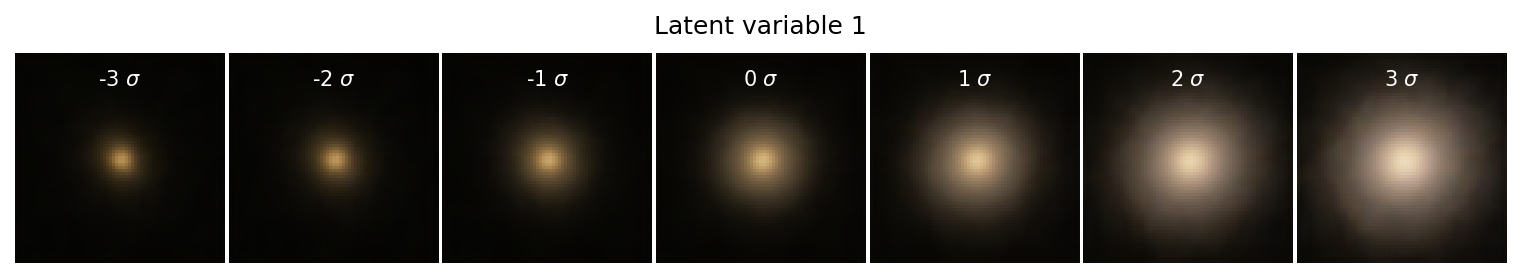

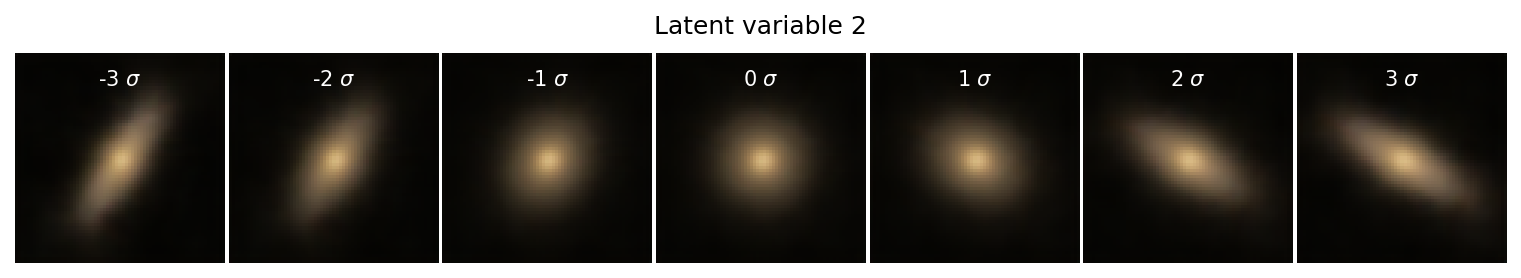

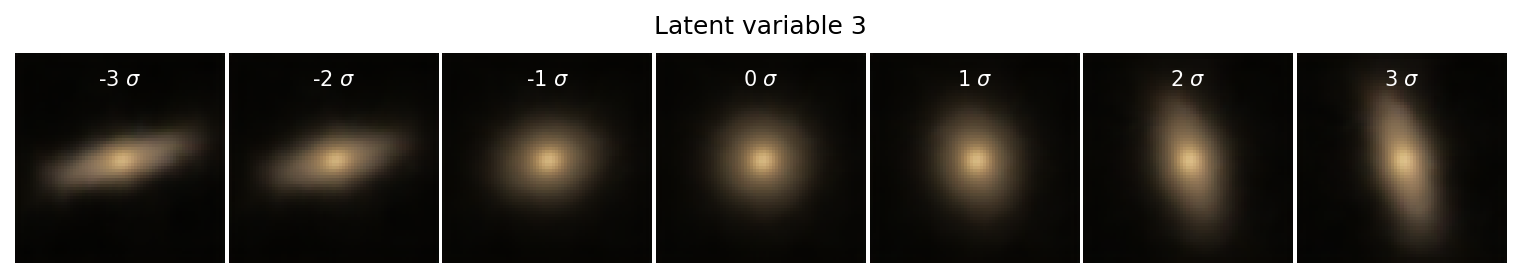

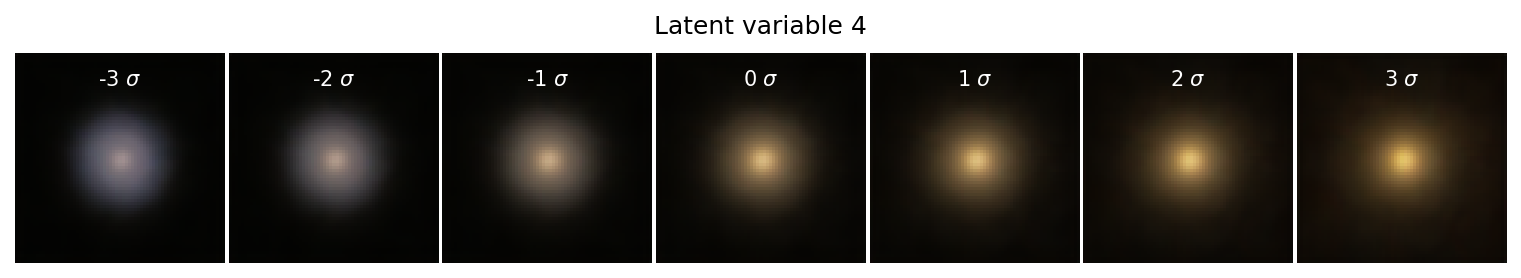

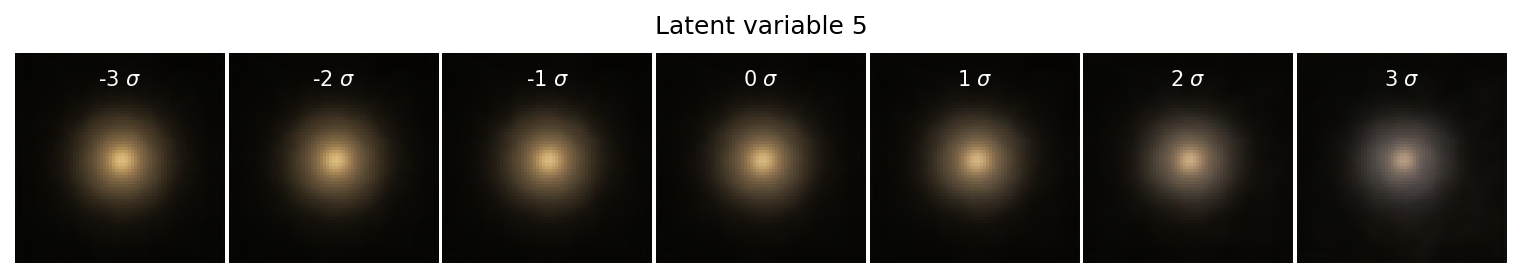

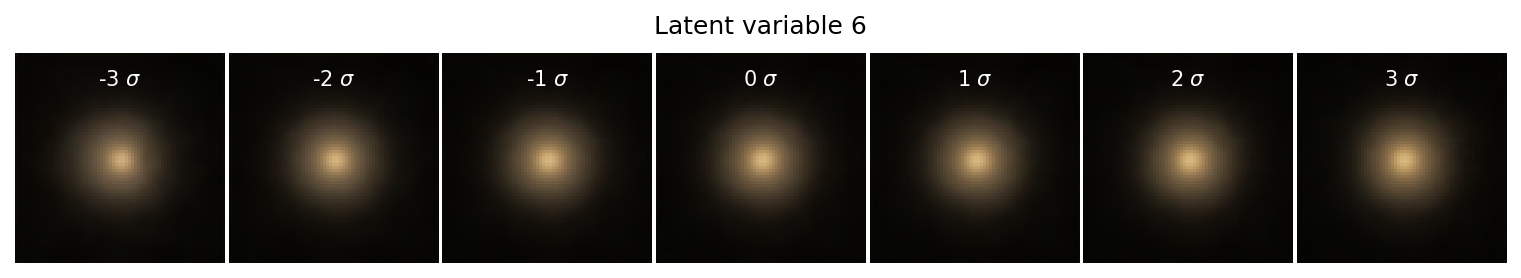

In [144]:
N_samples = 7


for d in range(0, 6):
    latent_vecs_pca = np.zeros((N_samples, 10))
    latent_vecs_pca[:, d] = latent_mu_stats[:, d]
    latent_vecs = pca.inverse_transform(latent_vecs_pca)

    latent_vecs = torch.FloatTensor(latent_vecs).to(device)

    x_reconstructed = decode(model, latent_vecs)

    in_ = np.array(x_reconstructed.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))

    N = 7
    plt.figure(figsize=(10, 2), dpi=150)
    plt.suptitle(f'Latent variable {d+1}')
    for n in range(N):
        plt.subplot(1, N, n + 1)
        plt.imshow(in_[n])
        plt.axis('off')
        plt.text(0.5, 0.85, str(n - 3) + r' $\sigma$', ha='center', transform=plt.gca().transAxes, color='white')
    plt.tight_layout(pad=0.2)
    plt.show()

## Make animated gif

In [257]:
# start at one end of the spectrum 

starting_vector = np.zeros((10,))
starting_vector[0] = -3
vecs = [starting_vector]

n = 0
# first latent var
for i in range(20):
    dv = np.zeros((10,))
    dv[0] = 0.3
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

# second latent var
for i in range(i, i+10):
    dv = np.zeros((10,))
    dv[1] = 0.3
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

# third latent var
for i in range(i, i+10):
    dv = np.zeros((10,))
    dv[2] = -0.3
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

#  to origin
for i in range(i, i+10):
    dv = np.zeros((10,))
    dv[0] = -0.3
    dv[1] = -0.3
    dv[2] = 0.3
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

for i in range(i, i+10):
    dv = np.zeros((10,))
    dv[3] = -0.3
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

for i in range(i, i+10):
    dv = np.zeros((10,))
    dv[1] = -0.3
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

for i in range(i, i+20):
    dv = np.zeros((10,))
    dv[1] = +0.3
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

for i in range(i, i+10):
    dv = np.zeros((10,))
    dv[0] = 0.3
    dv[1] = -0.3
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

for i in range(i, i+10):
    dv = np.zeros((10,))
    dv[0] = -0.3
    dv[2] = -0.3
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

for i in range(i, i+10):
    dv = np.zeros((10,))
    dv[0] = 0.3
    dv[3] = 0.15
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))

for i in range(i, i+10):
    dv = np.zeros((10,))
    dv[0] = -0.6
    dv[2] = 0.3
    dv[3] = 0.15
    vecs.append(vecs[n] + dv)
    n += 1

print(vecs[n].round(2))



[3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3. 3. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 3.  3. -3.  0.  0.  0.  0.  0.  0.  0.]
[-0. -0.  0.  0.  0.  0.  0.  0.  0.  0.]
[-0. -0.  0. -3.  0.  0.  0.  0.  0.  0.]
[-0. -3.  0. -3.  0.  0.  0.  0.  0.  0.]
[-0.  3.  0. -3.  0.  0.  0.  0.  0.  0.]
[ 3. -0.  0. -3.  0.  0.  0.  0.  0.  0.]
[-0. -0. -3. -3.  0.  0.  0.  0.  0.  0.]
[ 3.  -0.  -3.  -1.5  0.   0.   0.   0.   0.   0. ]
[-3. -0.  0. -0.  0.  0.  0.  0.  0.  0.]


In [258]:
vecs = np.stack(vecs)
latent_vecs = pca.inverse_transform(vecs)

latent_vecs = torch.FloatTensor(latent_vecs).to(device)

x_animation = decode(model, latent_vecs)

# matplotlib plottable form
x_ = np.array(x_animation.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [180]:
# !mkdir animation
# %cd animation

/content/animation/animation


In [262]:
for i, in_ in enumerate(x_):
    fig = plt.figure(figsize=(4,4), dpi=150)
    plt.imshow(in_)
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.savefig(f'{i:03d}.png')
    plt.close(fig)

In [263]:
!tar czf anim.tar.gz *.png

In [264]:
from google.colab import files
files.download('anim.tar.gz') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

You can download these and then convert using something like

    convert -dispose 2 -delay 5 -loop 0 *.png VAE-animation.gif

# Class-aware VAE

In [124]:
# number of classes
c = 10


class ConvVAE(nn.Module):
    def __init__(self, d, c):
        super().__init__()
        self.c = c
        self.d = d

        assert self.d > self.c

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, padding=1),    # 35x35
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 2, padding=1),   # 18x18
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.enc3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*18*18, 2*d)
        )

        self.dec1 = nn.Sequential(
            nn.Linear(d, 32*18*18),
            nn.Unflatten(1, (32, 18, 18)), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 1, padding=1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, 3, 1, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        mu_logvar = self.enc3(x).view(-1, 2, self.d)
        
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        probs = mu[:, :self.c]

        z = self.reparameterize(mu, logvar)

        x_hat = self.dec1(z)
        x_hat = F.interpolate(x_hat, size=(35, 35), mode='bilinear')

        x_hat = self.dec2(x_hat)
        x_hat = F.interpolate(x_hat, size=(69, 69), mode='bilinear')
        return self.dec3(x_hat), mu, logvar

In [125]:
def perceptual_categorical_MMD_loss(m, x_hat, x, mu, logvar, y, c=10, weights=[0.1, 1.0], alpha=1.0, beta=1.0):

    mse_f = torch.nn.MSELoss(reduction='sum')
    MSE = mse_f(x_hat, x) / x.size(1)

    with torch.no_grad():
        x_1 = m.enc1(x)
        x_2 = m.enc2(x_1)

        x_hat_1 = m.enc1(x_hat)
        x_hat_2 = m.enc2(x_hat_1)

        perceptual_1 = mse_f(x_1, x_hat_1) / x_1.size(1)
        perceptual_2 = mse_f(x_2, x_hat_2) / x_2.size(1)

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    true_samples = torch.autograd.Variable(
        torch.randn(200, model.d), 
        requires_grad=False
    ).to(device)
    z = model.reparameterize(mu, logvar) 
    MMD = compute_mmd(true_samples, z) * x.size(0) * model.d

    probs = mu[:, :c]
    CE = nn.CrossEntropyLoss(reduction='sum')(probs, y.long())

    return MSE + weights[0] * perceptual_1 + weights[1] * perceptual_2 + (1 - alpha)*KLD + (beta + alpha-1)*MMD + CE


In [126]:
model = ConvVAE(d=50, c=10).to(device)

learning_rate = 1e-4

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


 Epoch 0 | Train: 1247.0 | Valid: 1122.5


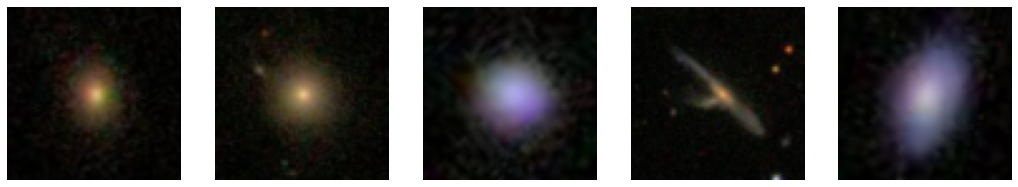

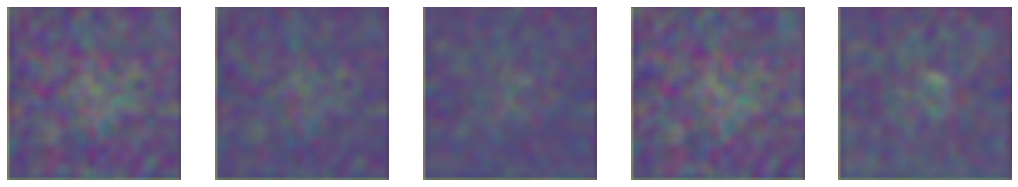

 Epoch 1 | Train: 694.0 | Valid: 447.3
 Epoch 2 | Train: 380.4 | Valid: 282.6
 Epoch 3 | Train: 257.6 | Valid: 191.9
 Epoch 4 | Train: 206.5 | Valid: 175.2
 Epoch 5 | Train: 179.2 | Valid: 151.3
 Epoch 6 | Train: 162.7 | Valid: 135.2
 Epoch 7 | Train: 151.6 | Valid: 127.2
 Epoch 8 | Train: 142.9 | Valid: 121.4
 Epoch 9 | Train: 136.0 | Valid: 116.7
 Epoch 10 | Train: 130.8 | Valid: 113.5


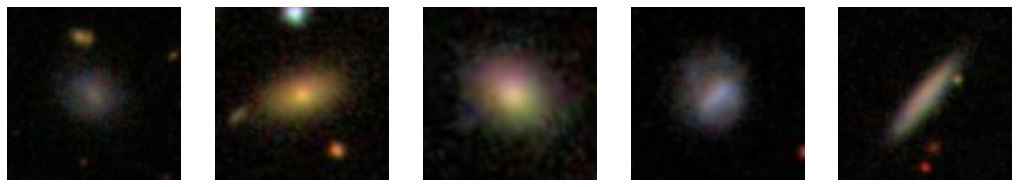

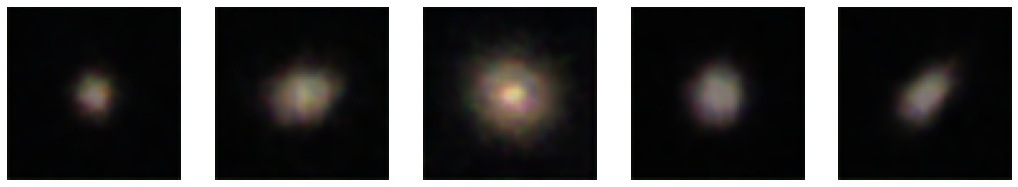

 Epoch 11 | Train: 126.4 | Valid: 108.4
 Epoch 12 | Train: 122.4 | Valid: 106.0
 Epoch 13 | Train: 118.6 | Valid: 105.0
 Epoch 14 | Train: 115.8 | Valid: 103.3
 Epoch 15 | Train: 112.5 | Valid: 100.5
 Epoch 16 | Train: 109.9 | Valid: 99.4
 Epoch 17 | Train: 107.6 | Valid: 96.2
 Epoch 18 | Train: 105.2 | Valid: 89.6
 Epoch 19 | Train: 103.1 | Valid: 93.6
 Epoch 20 | Train: 100.7 | Valid: 96.0


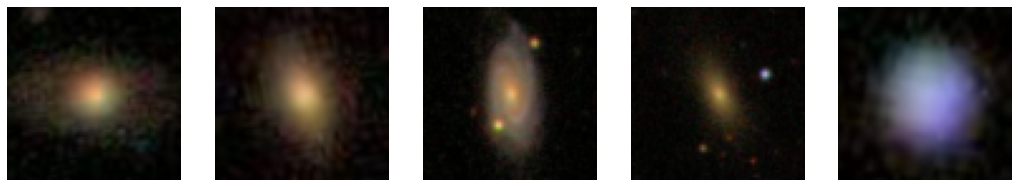

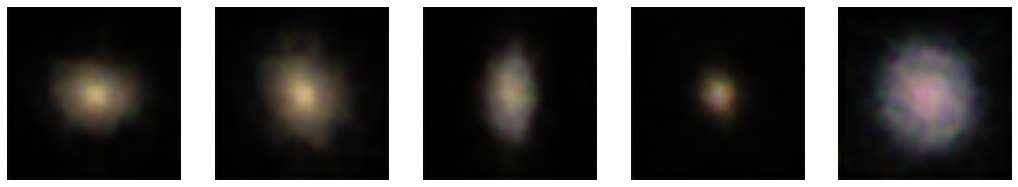

 Epoch 21 | Train: 99.0 | Valid: 86.6
 Epoch 22 | Train: 97.3 | Valid: 83.4
 Epoch 23 | Train: 95.2 | Valid: 86.8
 Epoch 24 | Train: 93.1 | Valid: 82.1
 Epoch 25 | Train: 91.4 | Valid: 82.5
 Epoch 26 | Train: 89.9 | Valid: 82.0
 Epoch 27 | Train: 88.2 | Valid: 76.8
 Epoch 28 | Train: 86.8 | Valid: 78.5
 Epoch 29 | Train: 85.5 | Valid: 76.8
 Epoch 30 | Train: 83.7 | Valid: 74.4


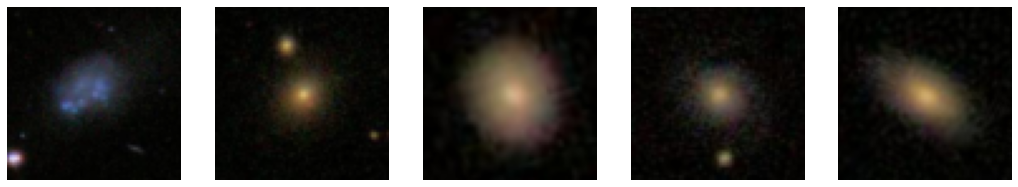

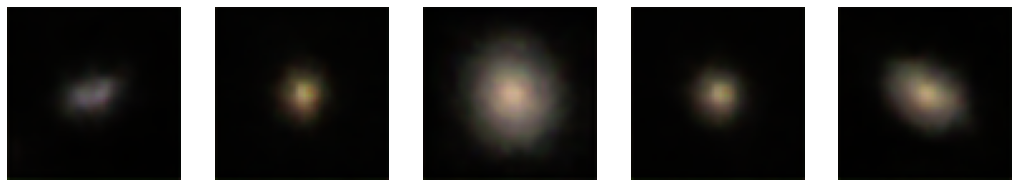

 Epoch 31 | Train: 82.4 | Valid: 76.6
 Epoch 32 | Train: 81.0 | Valid: 75.5
 Epoch 33 | Train: 79.6 | Valid: 72.6
 Epoch 34 | Train: 78.3 | Valid: 67.3
 Epoch 35 | Train: 76.7 | Valid: 66.3
 Epoch 36 | Train: 75.9 | Valid: 69.3
 Epoch 37 | Train: 74.2 | Valid: 63.7
 Epoch 38 | Train: 72.8 | Valid: 65.4
 Epoch 39 | Train: 71.9 | Valid: 67.3
 Epoch 40 | Train: 70.8 | Valid: 64.9


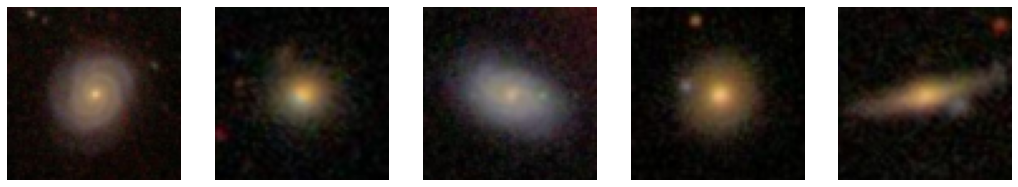

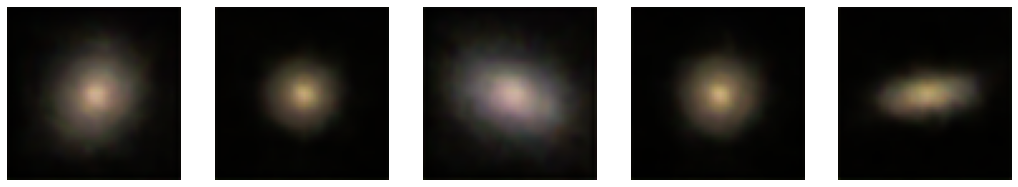

 Epoch 41 | Train: 69.6 | Valid: 67.3
 Epoch 42 | Train: 68.7 | Valid: 65.1
 Epoch 43 | Train: 67.6 | Valid: 64.8
 Epoch 44 | Train: 66.5 | Valid: 61.3
 Epoch 45 | Train: 65.8 | Valid: 61.8
 Epoch 46 | Train: 64.9 | Valid: 60.6
 Epoch 47 | Train: 64.2 | Valid: 60.8
 Epoch 48 | Train: 63.1 | Valid: 58.7
 Epoch 49 | Train: 62.3 | Valid: 58.0
 Epoch 50 | Train: 61.6 | Valid: 55.1


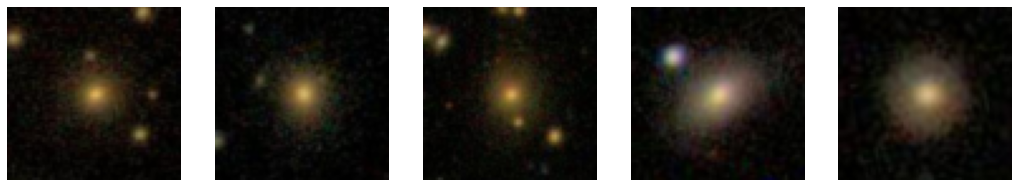

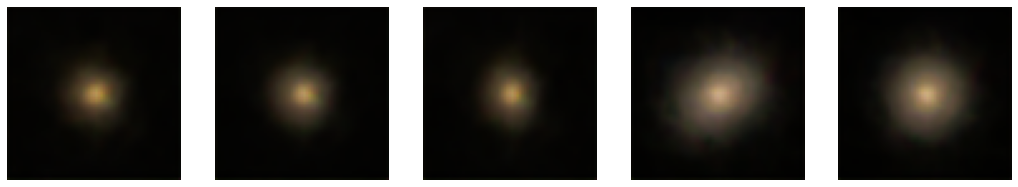

In [127]:
validation_losses = []

for epoch in range(0, 51):
    # train
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        x_hat, mu, logvar = model(x)
        loss = perceptual_categorical_MMD_loss(model, x_hat, x, mu, logvar, y, weights=[0.1, 1.], alpha=0.5, beta=1.)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    # validate
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            x_hat, mu, logvar = model(x)
            valid_loss += perceptual_categorical_MMD_loss(model, x_hat, x, mu, logvar, y, weights=[0.1, 1.], alpha=0.5, beta=1.)
        
    validation_losses.append(valid_loss / len(valid_loader.dataset))
    print(f' Epoch {epoch} | Train: {train_loss / len(train_loader.dataset):.1f} | Valid: {validation_losses[-1]:.1f}')

    # display
    if epoch % 10 == 0:
        display_images(x, x_hat, 1, 5)
        plt.show()

In [123]:
# for comparing which parts of loss cause largest gradients...
m = model.eval()

mse_f = torch.nn.MSELoss(reduction='sum')
MSE = mse_f(x_hat, x) / x.size(1)

with torch.no_grad():
    x_1 = m.enc1(x)
    x_2 = m.enc2(x_1)

    x_hat_1 = m.enc1(x_hat)
    x_hat_2 = m.enc2(x_hat_1)

    perceptual_1 = mse_f(x_1, x_hat_1) / x_1.size(1)
    perceptual_2 = mse_f(x_2, x_hat_2) / x_2.size(1)

KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

true_samples = torch.autograd.Variable(
    torch.randn(200, model.d), 
    requires_grad=False
).to(device)
z = model.reparameterize(mu, logvar) 
MMD = compute_mmd(true_samples, z) * x.size(0) * model.d

CE = nn.CrossEntropyLoss(reduction='sum')(probs, y.long())

print(MSE.cpu(), KLD.cpu(), MMD.cpu(), CE.cpu())

tensor(5873.7280, grad_fn=<CopyBackwards>) tensor(1182.5205, grad_fn=<CopyBackwards>) tensor(1804.5811, grad_fn=<CopyBackwards>) tensor(350.6532, grad_fn=<CopyBackwards>)


## Again look at features

In [128]:
mu_list = []
y_list = []
with torch.no_grad():
    model.eval()

    for x, y in valid_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        
        mu_list.append(mu)
        y_list.append(y)

mu_list = torch.cat(mu_list).cpu()
y_list = torch.cat(y_list).cpu()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [129]:
pca = PCA(n_components=10)
mu_pca_list = pca.fit_transform(mu_list)
pca.explained_variance_ratio_

array([0.29859444, 0.11673167, 0.09881396, 0.09248818, 0.08479024,
       0.03237859, 0.03178856, 0.02855394, 0.02217643, 0.01885337])

In [130]:
with torch.no_grad():
    model.eval()

    x, y = next(iter(valid_loader))

x = x.to(device)
x_hat, *_ = model(x)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [131]:
latent_mu_stats = np.array([np.quantile(mu_pca_list[:, i], [0.005, 0.025, 0.16, 0.5, 0.84, 0.975, 0.995]) for i in range(10)]).T

N_samples = 7

latent_vecs_pca = np.column_stack([latent_mu_stats[:, 0], np.zeros((N_samples, 9))])
latent_vecs = pca.inverse_transform(latent_vecs_pca)

latent_vecs = torch.FloatTensor(latent_vecs).to(device)

x_reconstructed = decode(model, latent_vecs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


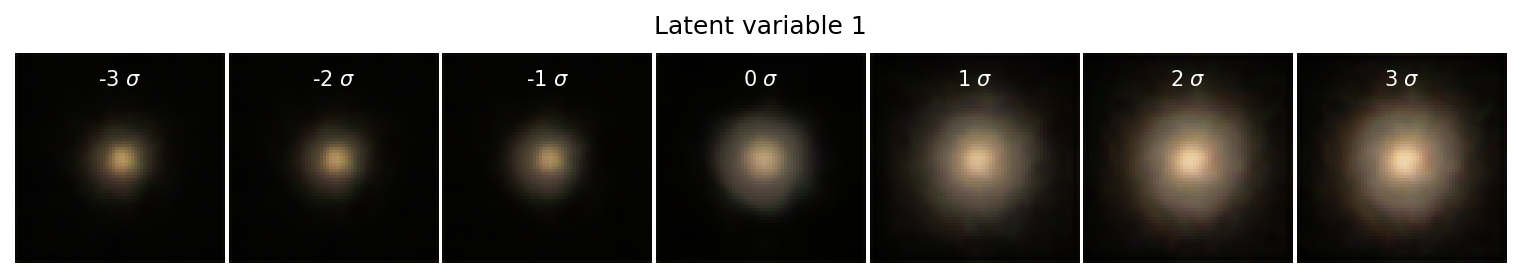

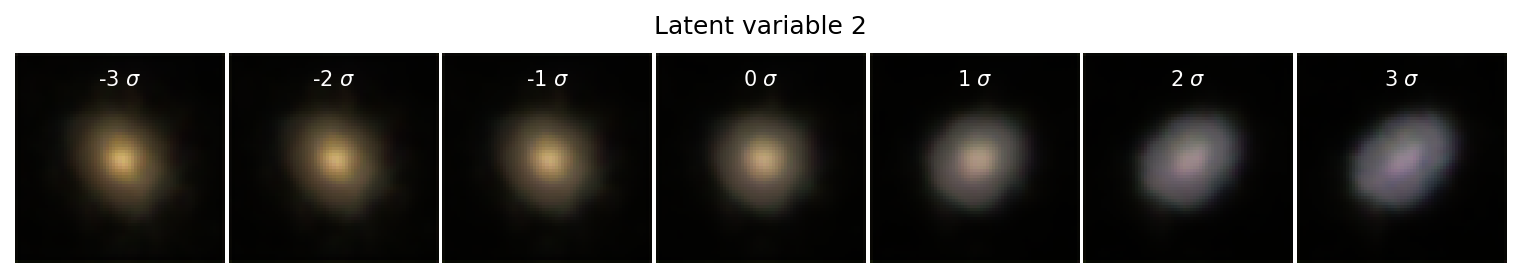

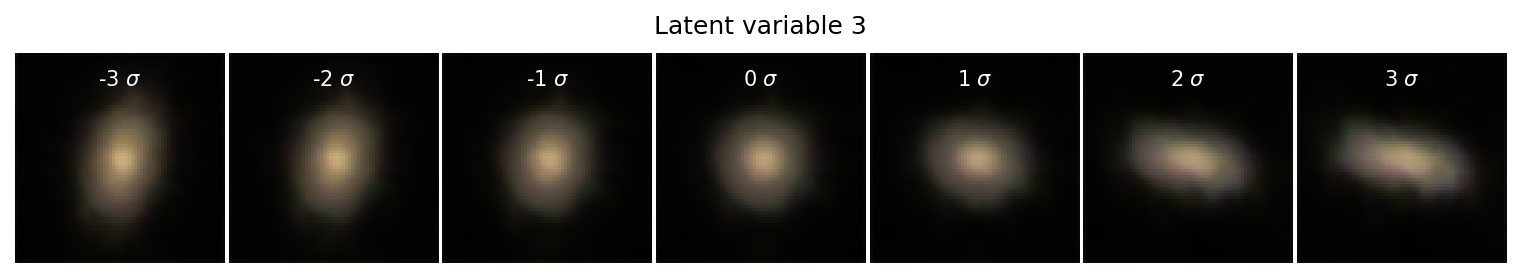

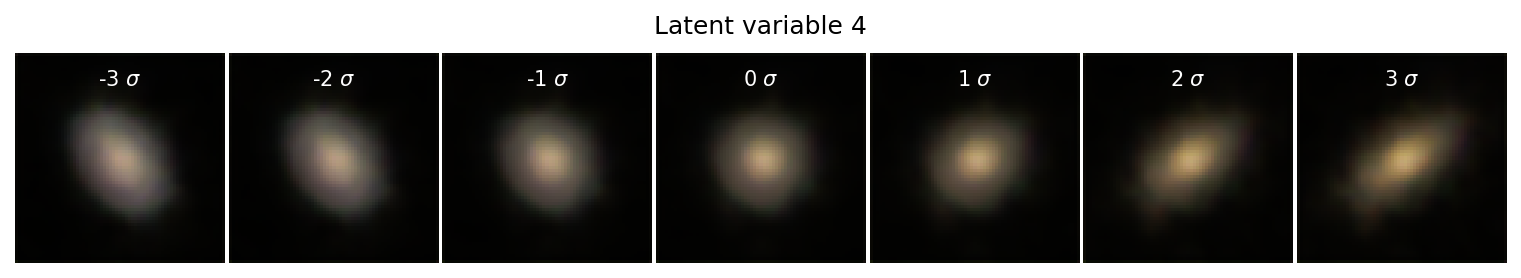

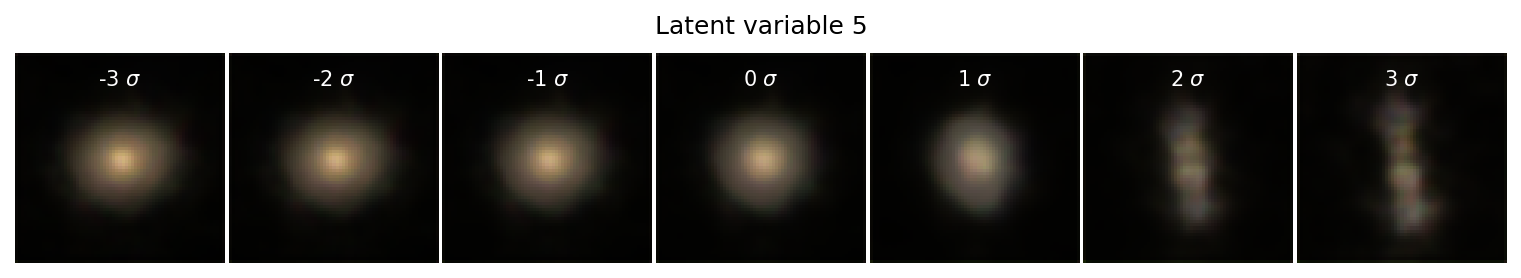

In [133]:
N_samples = 7


for d in range(0, 5):
    latent_vecs_pca = np.zeros((N_samples, 10))
    latent_vecs_pca[:, d] = latent_mu_stats[:, d]
    latent_vecs = pca.inverse_transform(latent_vecs_pca)

    latent_vecs = torch.FloatTensor(latent_vecs).to(device)

    x_reconstructed = decode(model, latent_vecs)

    in_ = np.array(x_reconstructed.data.cpu() * 255, dtype=int).transpose((0, 2, 3, 1))

    N = 7
    plt.figure(figsize=(10, 2), dpi=150)
    plt.suptitle(f'Latent variable {d+1}')
    for n in range(N):
        plt.subplot(1, N, n + 1)
        plt.imshow(in_[n])
        plt.axis('off')
        plt.text(0.5, 0.85, str(n - 3) + r' $\sigma$', ha='center', transform=plt.gca().transAxes, color='white')
    plt.tight_layout(pad=0.2)
    plt.show()